In [2]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [3]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 128298 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
# from google.colab import drive
# drive._mount('/content/drive')

In [10]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=7231dc93e7a3b32c89c369b194e7f68d9d3ba5aed8a52fad5631b2d36f4b2d75
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [11]:
import wandb
wandb.login()
#ec0fa02abb6680e2e41f9e94ffb3c3a636ca9007

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
%cd  '/content/drive/MyDrive/AI Project/Dataset1/'
# # /content/drive/MyDrive/AI Project/Dataset1/PlantVillage

/content/drive/MyDrive/AI Project/Dataset1


In [ ]:
%pwd

'/content/drive/MyDrive/AI Project/Dataset1'

In [13]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator 

In [14]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage'
width=256
height=256
depth=3
batch_size = 64

In [15]:
train_config = {"EPOCHS" : 25,
"INIT_LR" : 1e-3,
"BS" : 32,
"default_image_size" : tuple((256, 256)),
"image_size" : 0,
"directory_root" : '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage',
"width":256,
"height":256,
"depth":3,
"batch_size" : 64}

In [16]:
run = wandb.init(project="shuffleNet2", config=train_config)

wandb: Currently logged in as: prvns1997 (p1). Use `wandb login --relogin` to force relogin


In [17]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [18]:


data_path = '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage_15 classes/'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [19]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.3, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.7, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [ ]:
print(len(dataset['train']))
print(len(dataset['valid']))
print(len(dataset['test']))

14411
1853
4324


In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

In [22]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=False,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train/valid/test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  train/valid/test : 226 / 29 / 68


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#class distribution test

count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)

v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

In [ ]:
# imgtest = None
# for images, labels in dataloaders['train']:  
#     print(images)
#     print(labels)
#     imgtest = images[3]
#     print(imgtest.shape)
#     break

# imgtest = imgtest.numpy()
# imgtest = np.moveaxis(imgtest, 0, -1)
# imshow(imgtest)

In [23]:
# modeling
from torchvision import models
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.shufflenet_v2_x2_0(weights = None,num_classes=classes,progress=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [ ]:
dataloaders['train'] = DeviceDataLoader(dataloaders['train'], device)
dataloaders['valid'] = DeviceDataLoader(dataloaders['valid'], device)
dataloaders['test'] = DeviceDataLoader(dataloaders['test'], device)

In [ ]:
model = to_device(PlantDiseaseModel(classes=15), device) 
# model = PlantDiseaseModel(classes=len(count))
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
model


In [ ]:
# # defining the model and moving it to the GPU
# model = to_device(PlantDiseaseModel(len(train.classes)), device) 
# model

In [ ]:
device


In [ ]:
num_epochs = 20
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0
dev = device
since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    wandb.log({'epoch':(epoch+1)/num_epochs,'training_loss': trn_loss/batch_num['train'],'validation_loss': val_loss/batch_num['valid']})
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet2/best_model.pt')
print("model saved")

epoch: 1/20 | trn loss: 2.6844 | val loss: 2.6591 | 12m 57s elapsed
best model updated-epoch: 1 | val_accuracy: 7.2842
epoch: 2/20 | trn loss: 2.6577 | val loss: 2.6422 | 16m 0s elapsed
best model updated-epoch: 2 | val_accuracy: 7.8166
epoch: 3/20 | trn loss: 2.6410 | val loss: 2.6230 | 19m 4s elapsed
best model updated-epoch: 3 | val_accuracy: 8.7362
epoch: 4/20 | trn loss: 2.6262 | val loss: 2.6120 | 22m 9s elapsed
best model updated-epoch: 4 | val_accuracy: 9.4138
epoch: 5/20 | trn loss: 2.6148 | val loss: 2.6027 | 25m 12s elapsed
best model updated-epoch: 5 | val_accuracy: 9.8252
epoch: 6/20 | trn loss: 2.6045 | val loss: 2.5913 | 28m 12s elapsed
best model updated-epoch: 6 | val_accuracy: 10.2608
epoch: 7/20 | trn loss: 2.5914 | val loss: 2.5821 | 31m 10s elapsed
best model updated-epoch: 7 | val_accuracy: 10.5028
epoch: 8/20 | trn loss: 2.5823 | val loss: 2.5751 | 34m 12s elapsed
best model updated-epoch: 8 | val_accuracy: 10.6238
epoch: 9/20 | trn loss: 2.5761 | val loss: 2.568

In [ ]:
!pwd

In [ ]:
print(trn_loss_list)

In [ ]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

In [ ]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [ ]:
# best_model = PlantDiseaseModel()
# best_model.load_state_dict(torch.load('best_model.pt'))


In [ ]:
%pwd

In [ ]:
corrects = 0
total = 0
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model = best_model.to(device)
# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in dataloaders['test']:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precision: 0.1126, Recall: 0.2409, F-score: 0.1467
Confusion matrix:
 [[  0   0   0   0   0   2   0   0   0  87 120   0   9   0   0]
 [  0   0   0   0   0  34   0   0   0  88 173   0  27   0   0]
 [  0   0   0   0   0   5   0   0   0 170  55   0   0   0   0]
 [  0   0   0   0   0  58   0   0   0  18 103   0   4   0   0]
 [  0   0   0   0   0   0   0   0   0   7  15   0   0   0   0]
 [  0   0   0   0   0 403   0   0   0   0   1   0  16   0   0]
 [  0   0   0   0   0  63   0   0   0  40  46   0  33   0   0]
 [  0   0   0   0   0 157   0   0   0  85 127   0  40   0   0]
 [  0   0   0   0   0  29   0   0   0  55  80   0  36   0   0]
 [  0   0   0   0   0  15   0   0   0 306  50   0   2   0   0]
 [  0   0   0   0   0   6   0   0   0   9 292   0  26   0   0]
 [  0   0   0   0   0  18   0   0   0  97 169   0   4   0   0]
 [  0   0   0   0   0   5   0   0   0   0  26   0 678   0   0]
 [  0   0   0   0   0   0   0   0   0  54  23   0   1   0   0]
 [  0   0   0   0   0 147   0   0   0  66 144   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


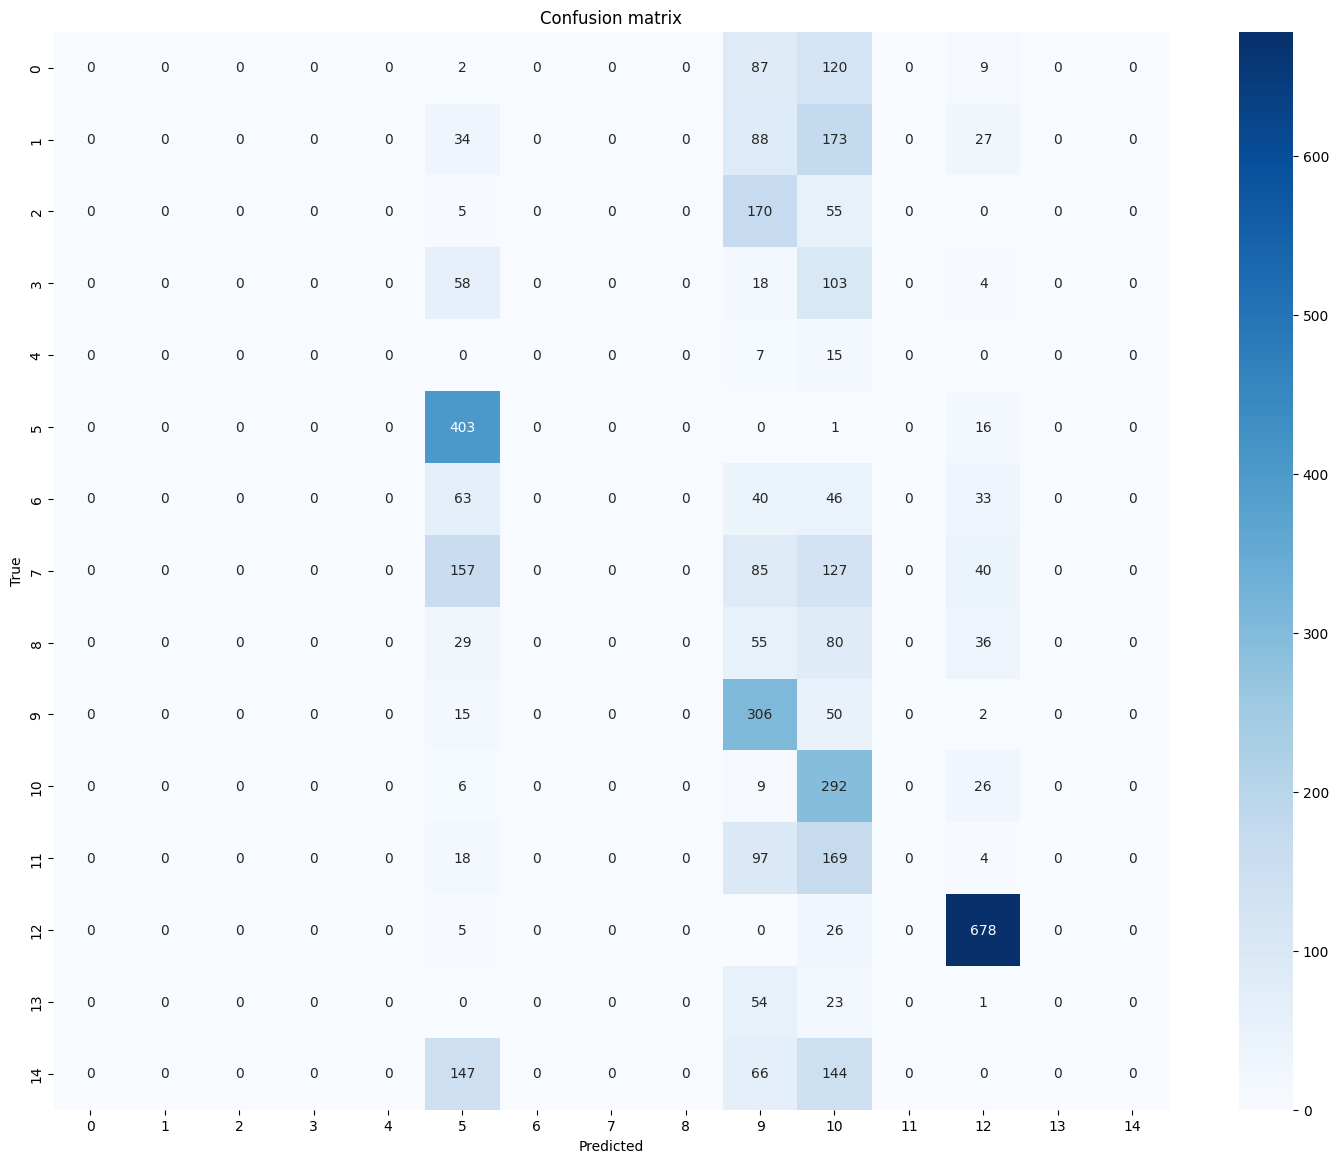

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
